# Result Collection, Regional population projection

#### may 2022 version
only the output part

### email from Sturla


I want a file with a few different policy relavant population aggregates:
•	Total population 
•	Population in childcare age (1-5 at end of year)  
•	Population in primary school age (age 6-12 at the end of year)  
•	Population in lower secondary school age (age 13-15 at the end of year)  
•	Elderly population (80+ at end of year)
•	Very old population (90+ at end of year)

We should have one observation of the number of people in these groups across all municipalities, years and simulations. Returning a file with variables: knr, year, sim_id, pop_all, pop0105, pop0612, pop1315, pop8000 pop9000 and 10m obs (356*29*1000). 


#### Python scripts to collect and orgainze the simulation results from microsimulations.
Input files:
- sim_outxxx.pkl
generated using sim_main.py, the parameters can be set through sim_para.py.
the python scripts using paralle computational techinque and can be ran on server stata-p3 using python3 command directly from command line. 


In [1]:
### libary importation and some global parameters:

import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as spo
import pandas as pd
import seaborn as sns
import subprocess
import os 
from itertools import compress
import copy
import pickle
from dapla import FileClient

pd.set_option('float_format', '{:f}'.format)


In [2]:
import sim_para



# maxage=120
# range_fertility=49-15+1
# max_year=31
# number_region=356
# move_age=69


sim_mark=sim_para.sim_mark

path = sim_para.path
outpath=sim_para.outpath
max_year=sim_para.max_year
base_year=sim_para.base_year
move_age=sim_para.move_age
number_region=sim_para.number_region
maxage=sim_para.maxage
range_fertility=sim_para.range_fertility
start_year=sim_para.start_year
png_dir=path+'/gif_dir/'
workpath=sim_para.workpath

## simulation results are saved with suffixes 'xxx' so that different 
## simulation runs can be used

# run_index_list=['2', '3', '4']
run_index_list=[str(i) for i in range(sim_para.number_loop)]
#for i in range(4):
#    run_index_list.pop(0)

## select the three regions

region_selection=[0, 22, 122, 227]
region_name=['Oslo','Utsira', 'Eidsvoll', 'Bygland']

Region_label=["county "+str(i)+" " for i in range(1, number_region+1)]
Region_label[122]='Eidsvoll'  
Region_label[0]='Oslo'  
Region_label[22]='Utsira'
Region_label[227]='Bygland'  
Region_label.append("nationwide ")

total number of available CPUs is 80


## input simulation results

In [3]:
fs = FileClient.get_gcs_file_system()
res=[]
## read in the simulatin rsults
run_index_list=[str(i) for i in range(400)]
for index in run_index_list:
    with fs.open(workpath+'/sim_out'+'dapla'+index+'.pkl', mode='rb') as file:
        res.append(pickle.load(file))
run_index_list=[str(i) for i in range(519)]
for index in run_index_list:
    with fs.open(workpath+'/sim_out'+sim_mark+index+'.pkl', mode='rb') as file:
        res.append(pickle.load(file))

In [4]:
## find out the number of simulations and number of prediction years
number_loop=len(res)
print('simulation number ',number_loop)
number_year=len(res[0][0])-1
print("simulate %s years" % number_year)

simulation number  919
simulate 29 years


In [5]:
## separate the informations

'''
# the structure of the output
# list 
## first level: index simulation runs, list [number_loop]
## second level: [0] summary of population, list [number_year]
                         3 dimensional array [age, sex, region]
                 [1] summary of immigrants, list [number_year]
                         3 dimensional array [age, sex, region]
                 [2] summary of newborns, 
                         2 dimensional array [sex, region]
                 [3] summary of deaths,     
                         3 dimensional array [age, sex, region]
                 [4] summary of outmigrants,
                         3 dimensional array [age, sex, region]                
                 [5] summary of in-country mover,
                         4 dimensional array [age, sex, region, 2]
We reorganize this to 5 listst ,which correspond to the above 5 different information and have the same structure
'''
sim_size_full=[]
sim_im=[]
sim_newborn=[]
sim_dead=[]
sim_out=[]
sim_move=[]
sim_totalnewborn=[]
sim_fertile=[]
sim_fertile_actual=[]

for i in range(len(res)):
    sim_size_full.append(res[i][0])
    sim_im.append(res[i][1])
    sim_newborn.append(res[i][2])
    sim_dead.append(res[i][3]) 
    sim_out.append(res[i][4]) 
    sim_move.append(res[i][5])
    sim_fertile.append(res[i][6])
    sim_fertile_actual.append(res[i][7])
    sim_totalnewborn.append([np.sum(res[i][2][j]) for j in range(number_year+1)])

len(sim_size_full)


919

In [6]:

temp_sim_size_full=np.sum(sim_size_full, 0)/number_loop
temp_sim_dead=np.sum(sim_dead, 0)/number_loop
temp_sim_im=np.sum(sim_im, 0)/number_loop
temp_sim_out=np.sum(sim_out, 0)/number_loop
temp_sim_newborn=np.sum(sim_newborn, 0)/number_loop
temp_sim_move=np.sum(sim_move, 0)/number_loop

res_sim_size_full=np.zeros((number_year+1,120,2,356))
res_sim_dead=np.zeros((number_year+1,120,2,356))
res_sim_newborn=np.zeros((number_year+1,2,356))
res_sim_im=np.zeros((number_year+1,120,2,356))
res_sim_out=np.zeros((number_year+1,120,2,356))
res_sim_move=np.zeros((number_year+1,120,2,356,2))

                    
for i in range(number_year+1):
    #print(i)
    for j in range(120):
        for k in range(2):
            for l in range(356):
                res_sim_size_full[i,j,k,l]=temp_sim_size_full[i][j,k,l]
                res_sim_dead[i,j,k,l]=temp_sim_dead[i][j,k,l]
                if j==0:
                    res_sim_newborn[i,k,l]=temp_sim_newborn[i][k,l]
                if j<=move_age:
                    res_sim_im[i,j,k,l]=temp_sim_im[i][j,k,l]
                    res_sim_out[i,j,k,l]=temp_sim_out[i][j,k,l]
                    # moving out of region l
                    res_sim_move[i,j,k,l,0]=temp_sim_move[i,j,k,l,0]
                    res_sim_move[i,j,k,l,1]=temp_sim_move[i,j,k,l,1]


In [7]:
## generate a array with number of total population at year 25 for selected regions.
#
pop_size_selected=np.zeros((number_loop, len(region_selection)))
p_year=number_year
for j in range(len(region_selection)):
    pop_size_selected[:,j]=[np.sum([sim_size_full[i][p_year][:,:,region_selection[j]]]) for i in range(number_loop)]

In [8]:
#pd.DataFrame(pop_size_selected).to_csv(path+"/pop_region.csv")
outfile=outpath+'/pop_region.csv'
FileClient.save_pandas_to_csv(pd.DataFrame(pop_size_selected), f"{outfile}") 
print("done")

done


In [9]:
print(sim_totalnewborn[:2])
out=np.zeros((number_loop, number_year+1))
for j in range(number_year+1):
    out[:,j]=[sim_totalnewborn[i][j] for i in range(number_loop)]


[[0.0, 54218.0, 54437.0, 54042.0, 54501.0, 55571.0, 55206.0, 56035.0, 56585.0, 57138.0, 57011.0, 58148.0, 58521.0, 59247.0, 59993.0, 60344.0, 59954.0, 59893.0, 59650.0, 59538.0, 59288.0, 59089.0, 58401.0, 58350.0, 58218.0, 57562.0, 57368.0, 56722.0, 56473.0, 56326.0], [0.0, 54266.0, 54438.0, 54569.0, 54837.0, 55377.0, 55439.0, 56133.0, 56665.0, 56630.0, 57586.0, 57460.0, 58225.0, 58730.0, 58708.0, 59631.0, 59936.0, 60062.0, 59494.0, 59393.0, 59141.0, 59327.0, 58560.0, 58386.0, 58336.0, 57581.0, 57100.0, 56930.0, 56382.0, 56638.0]]


In [10]:
fertility_table=[np.zeros((number_region,range_fertility)) for i in range(max_year)]

def set_fertility(file):
    datafile=path+'/'+file
    data_in=pd.read_csv(datafile)  
        #print(data_in)
    for index, row in data_in.iterrows():
        # index_temp starts at zero
        index_temp=int(row.year-base_year-1)
        # region: 0-355
        r=int(row.region)
        #age starts from 15
        a=int(row.age)-15
        fertility_table[index_temp][r,a]=row.prob 
        
set_fertility("fertility.csv")
        
# calculate teh expected number of birth
count=np.zeros((number_loop,number_year))
birth=np.zeros((number_loop,number_year))

for ii in range(number_loop):
    for i in range(number_year):
        year=base_year+i+1
        for r in range(number_region):
            for j in range(range_fertility):
                # take the number of females (aged 14 to 48 at the end of last year) 
                a=14+j
                birth[ii,i]=birth[ii,i]+sim_size_full[ii][i][a,1,r]*fertility_table[i][r,j]
                #birth[ii,i]=birth[ii,i]+sim_size_full[ii][i][a,1,r]*0.05
                count[ii,i]=count[ii,i]+sim_size_full[ii][i][a,1,r]

# the simulated birth
for i in range(number_year):
    #number of total fertile women
    print("year ", start_year+i)
    print("average number of fertile women", np.sum(count[:,i])/number_loop)
    a=np.sum(birth[:,i])/number_loop
    b=np.sum(out[:,i+1])/number_loop
    diff=a-b
    print(a, b, diff)
    for j in range(10):
        start=j*100
        stop=(j+1)*100
        a=np.sum(birth[start:stop,i])/100
        b=np.sum(out[start:stop,i+1])/100
        diff=a-b
        print(j, a, b, diff)
            

year  2022
average number of fertile women 1202964.0
54571.35372066355 54571.9281828074 -0.5744621438498143
0 54571.35372066352 54573.12 -1.7662793364797835
1 54571.35372066352 54533.96 37.39372066352371
2 54571.35372066352 54616.64 -45.28627933647658
3 54571.35372066352 54578.83 -7.47627933647891
4 54571.35372066352 54540.77 30.583720663526037
5 54571.35372066352 54535.52 35.83372066352604
6 54571.35372066352 54592.55 -21.196279336480075
7 54571.35372066352 54576.15 -4.796279336478619
8 54571.35372066352 54600.58 -29.22627933647891
9 10368.557206926072 10367.9 0.6572069260728313
year  2023
average number of fertile women 1213435.2829162134
54426.39433677059 54429.007616974974 -2.613280204386683
0 54425.740473896476 54407.09 18.650473896479525
1 54424.06041149536 54476.96 -52.899588504638814
2 54425.981273886326 54391.19 34.791273886323324
3 54429.59218593175 54455.44 -25.847814068249136
4 54428.97728773361 54428.39 0.5872877336078091
5 54424.128746672526 54434.5 -10.371253327473823
6 

In [11]:
# make the array into a dataframe, where there are (number_year+1)*121*2*356 lines
# where columns are 'year_projection', 'age', 'gender', 'region', 'population'

lines=(number_year+1)*121*2*356

c=0
sim_output=np.zeros([lines,5])
for i in range(number_year+1):
    for j in range(120):
        for k in range(2):
            for l in range(356):
                sim_output[c,0]=i
                sim_output[c,1]=j
                sim_output[c,2]=k
                sim_output[c,3]=l
                sim_output[c,4]=res_sim_size_full[i,j,k,l]
                c += 1
df_sim_size=pd.DataFrame(sim_output)
df_sim_size.columns=['year_projection', 'age', 'gender', 'region', 'population']

# look at the projection for year 15 (year=0 is the base year)
df_sim_size[df_sim_size['year_projection']==15].head()

,year_projection,age,gender,region,population
1281600,15.000000,0.000000,0.000000,0.000000,5035.548422
1281601,15.000000,0.000000,0.000000,1.000000,74.261153
1281602,15.000000,0.000000,0.000000,2.000000,864.594124
1281603,15.000000,0.000000,0.000000,3.000000,199.134929
1281604,15.000000,0.000000,0.000000,4.000000,539.023939


In [12]:
df_sim_size[df_sim_size['age']==120].sum()

year_projection   0.000000
age               0.000000
gender            0.000000
region            0.000000
population        0.000000
dtype: float64

In [13]:
# ## get the knr variable into the dataframe 
# and save to output file

#from dapla import FileClient

#datafile=path+'/'+'population.csv'
#data_population=pd.read_csv(datafile)

#a=data_population['knr'].unique()
#a.sort()

#df_knr=pd.DataFrame(a)

#df_knr.reset_index(inplace=True)

#df_knr.head()

#df_knr.columns=['region', 'knr' ]

#df_knr.to_csv(path+'/'+'df_knr.csv', index=False)

In [14]:


df_knr=pd.read_csv(path+'/'+'df_knr.csv')

print(df_knr.head())

## merge the region variable in

df_pop=df_sim_size.merge(df_knr, on='region')

df_pop.drop(columns=['region'], inplace=True)

# df_pop[(df_pop['year_projection']==15) & (df_pop['age']==55)].tail()

#df_pop.to_csv(path+'/'+'population_sim.csv', index=False)
outfile=outpath+'/'+'population_sim.csv'
FileClient.save_pandas_to_csv(df_pop, f"{outfile}") 

   region   knr
0       0   301
1       1  1101
2       2  1103
3       3  1106
4       4  1108


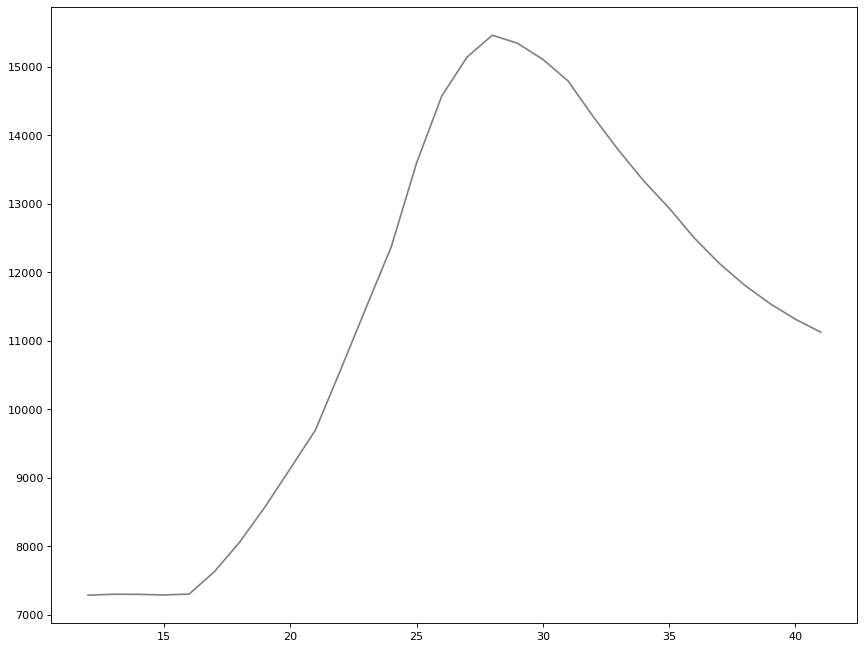

In [15]:
## check cohort 
df_pop['year']=df_pop['year_projection']+base_year+1
df_pop['cohort']=df_pop['year']-df_pop['age']

df_oslo=df_pop[(df_pop['knr']==301) & (df_pop['cohort']==2010)].groupby('age', as_index=False).sum()
df_oslo.head()

# plot the number of the 2010 cohort at Oslo

plt.figure(figsize=(13,10), dpi= 80)
plt.plot(df_oslo['age'], df_oslo['population'], '-', color='gray')
plt.show()

Components by municipality and year (6outcomes x 356munic x 30years)
-	Births
-	Deaths
-	Immigrations
-	Emigrations
-	In-migrations (domestic)
-	Out-migration (domestic)


In [16]:
## imput the size of emigrants and out-emigrants
im_size=np.zeros(31)
em_size=np.zeros(31)

def set_im_size(file):
    datafile=path+'/'+file
    data_in=pd.read_csv(datafile)
    for index, row in data_in.iterrows():
        index_temp=int(row.year-base_year-1)       
        im_size[index_temp]=(row.tot_immigrants)
        em_size[index_temp]=(row.tot_emigrants)

set_im_size("tot_migration.csv")

In [17]:
# res_sim_size_full[time_index,age,gender,region]
print(res_sim_size_full[0,:,:,:].sum())
print(res_sim_size_full[0,4,0,0])

5425270.0
3866.0


In [18]:
lines=(number_year+1)*121*2*356

c=0
sim_out_2=np.zeros([lines,10])

for i in range(number_year+1):
    #print(i)
    for j in range(120):
        for k in range(2):
            for l in range(356):
                sim_out_2[c,0]=i
                sim_out_2[c,1]=j
                sim_out_2[c,2]=k
                sim_out_2[c,3]=l
                sim_out_2[c,6]=res_sim_dead[i,j,k,l]
                if j==0:
                    sim_out_2[c,5]=res_sim_newborn[i,k,l]
                if j<= move_age:
                    sim_out_2[c,4]=res_sim_im[i,j,k,l]
                    sim_out_2[c,7]=res_sim_out[i,j,k,l]
                    sim_out_2[c,8]=np.sum(res_sim_move[i,j,k,l,0])
                    sim_out_2[c,9]=np.sum(res_sim_move[i,j,k,l,1])
                c += 1
df_sim_size_2=pd.DataFrame(sim_out_2)
df_sim_size_2.columns=['year_projection', 'age', 'sex', 'region', 'immigrants', 'births', 'deaths', 'outmigrants', 'move_out', 'move_in']
df_sim_size_2.head()


,year_projection,age,sex,region,immigrants,births,deaths,outmigrants,move_out,move_in
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [19]:

## nationwide outmigration by project year
print('year  simulated size   given size')
for i in range(number_year):
    print(i+start_year, np.sum(res_sim_out[i+1,:,:,:]), em_size[i])


year  simulated size   given size
2022 29877.08922742111 29874.795
2023 30955.560391730145 30958.881
2024 31485.67464635473 31489.813
2025 30628.520130576715 30619.359
2026 30143.23286180631 30141.605
2027 29755.64417845484 29759.775
2028 29260.946681175188 29258.359
2029 28972.73667029379 28972.711
2030 28855.964091403697 28861.566
2031 28829.878128400436 28831.84
2032 28693.092491838957 28687.543
2033 28518.755168661588 28519.953
2034 28410.242655059847 28406.566
2035 28360.15778019587 28346.607
2036 28292.29815016322 28283.5
2037 28218.947769314473 28214.803
2038 28131.807399347115 28134.764
2039 28046.028291621325 28052.191
2040 27959.00979325354 27961.836
2041 27881.0957562568 27870.889
2042 27786.30794341676 27774.432
2043 27676.510337323176 27677.932
2044 27564.653971708372 27572.135
2045 27462.003264417846 27465.947
2046 27345.595212187156 27352.092
2047 27235.76278563656 27235.6
2048 27116.56800870511 27110.551
2049 26975.210010881394 26978.48
2050 26832.983677910775 26836.141

In [20]:
df_pop=df_sim_size_2.merge(df_knr, on='region')

df_pop.drop(columns=['region'], inplace=True)

# check consistency between move in/out
print(df_pop[df_pop['year_projection']==1]['move_out'].sum())
print(df_pop[df_pop['year_projection']==1]['move_in'].sum())

#df_pop.to_csv(path+'/'+'components_sim.csv', index=False)
outfile=outpath+'/'+'components_sim.csv'
FileClient.save_pandas_to_csv(df_pop, f"{outfile}") 

216051.613710555
216051.61371055496


## Output File requested by Sturla for the report

I want a file with a few different policy relavant population aggregates:
 - 	Total population 
 - 	Population in childcare age (1-5 at end of year)  
 - 	Population in primary school age (age 6-12 at the end of year)  
 - 	Population in lower secondary school age (age 13-15 at the end of year)  
 - 	Elderly population (80+ at end of year)
 - 	Very old population (90+ at end of year)

We should have one observation of the number of people in these groups across all municipalities, years and simulations. Returning a file with variables: knr, year, sim_id, pop_all, pop0105, pop0612, pop1315, pop8000 pop9000 and 10m obs (356*29*1000). 


All information is based on the number of residents, so we work with sim_size_full

sim_size_full is a list (number_loop) of lists (number_year) of 3 dimensional array [age, sex, region]

#### sim_size_full[i][j][a,s,r]

denotes the number of projected population size for 
- sim loop i 
- projection year [base_year+j]
- of age a, sex s in region r

list_out=[]
for i in range(1):
    for j in range(1):
        temp=sim_size_full[i][j+1]
        for r in range(1):
        # loop, projection year, region, total population, childcare,primary, lower, elderly, 
        list_temp=[i+1, start_year+j, r, np.sum(temp[:,:,r]), np.sum(temp[1:6,:,r]), np.sum(temp[6:13,:,r]),  np.sum(temp[13:16,:,r]), np.sum(temp[80:,:,r]), np.sum(temp[90:,:,r])]
        list_out.append(list_temp)
        

In [21]:
# I want a file with a few different policy relavant population aggregates:
#  Total population 
#  Population in childcare age (1-5 at end of year)  
#  Population in primary school age (age 6-12 at the end of year)  
#  Population in lower secondary school age (age 13-15 at the end of year)  
#  Elderly population (80+ at end of year)
#  Very old population (90+ at end of year)

# We should have one observation of the number of people in these groups across all municipalities, 
# years and simulations. Returning a file with variables: knr, year, sim_id, pop_all, pop0105, pop0612, 
# pop1315, pop8000 pop9000 and 10m obs (356*29*1000). 



list_out=[]
for i in range(number_loop):
    #print("loop nr. ", i)
    for j in range(number_year):
        temp=res[i][0][j+1]
        for r in range(number_region):
        # loop, projection year, region, total population, childcare,primary, lower, elderly,over90
            list_temp=[i+1, start_year+j, r, np.sum(temp[:,:,r]), np.sum(temp[1:6,:,r]), np.sum(temp[6:13,:,r]),  np.sum(temp[13:16,:,r]), np.sum(temp[80:,:,r]), np.sum(temp[90:,:,r])]
            list_out.append(list_temp)

test_out=pd.DataFrame(list_out)

print("df generated")

df_knr=pd.read_csv(path+'/'+'df_knr.csv')

test_out.set_axis(["sim_id", "year", "region", "pop_all", "pop0105", "pop0612", "pop1315", "pop8000", "pop9000"], axis=1, inplace=True)

df_uncertainty=test_out.merge(df_knr, on='region')
df_uncertainty.drop(columns=['region'], inplace=True)

#df_uncertainty.to_csv(path+'/'+'uncertainty_sim.csv', index=False)
outfile=outpath+'/'+'uncertainty_sim.csv'
FileClient.save_pandas_to_csv(df_uncertainty, f"{outfile}") 

df generated


/tmp/ipykernel_176/3584665612.py:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  test_out.set_axis(["sim_id", "year", "region", "pop_all", "pop0105", "pop0612", "pop1315", "pop8000", "pop9000"], axis=1, inplace=True)


In [ ]:
res